In [1]:
import numpy as np
import heartpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
import sys
from datetime import datetime
# Automatic Gain Control=Checked,IR PA (mA)=10,Red PA (mA)=10,IR LED Range (mA)=51,Red LED Range (mA)=51,ALC + FDM=Checked,
# Sample Rate (Hz)=100,Pulse Width (usec)=400,ADC Range (nA)=32768,FIFO Rolls on Full=Checked,FIFO Almost Full=17,Sample 
# Averaging=1,IA Gain=5,ECG Gain=8,Sample Rate=200,Adaptive Filter=Checked,Notch Freq=60,Cutoff Freq=50,

In [51]:
### Peak Finding Parameters ###
MIN_WIDTH = 25
MAX_WIDTH = 500
PROMINENCE_IR = 1000
PROMINENCE_RED = 500
HEIGHT = None
THRESHOLD = None

### SpO2 Parameters ###
a = -16.666666 # SpO2 = aR^2 + bR + c
b = 8.333333
c = 100 # goofy values from Maxim

#DIAG
compute_moving_average = 0

In [36]:
def convert_to_sec(t):
    timelist_ms = np.array(t - t[0], dtype=float)
    timelist_s = timelist_ms/1000
    return timelist_ms, timelist_s

def smooth_data(dataset, analysis_type):
    """Takes in a dataset and smoothes the data for
    analysis.

    Args:
        dataset (DataFrame): a dataframe containing the necessary data
        analysis_type (string): what data to smooth down

    Returns:
        Array: the filtered signal
    """
    #read in data
    if analysis_type.lower() == 'ir':
        signal = dataset[' IR Count']
    elif analysis_type.lower() == 'red':
        signal = dataset[' Red Count']
    else:
        sys.exit("Wrong input for analysis_type. Accepted values are 'ir' or 'red'.")
    

    #filter signal using bandpass
    filtered = hp.filter_signal(signal, [0.5, 4], sample_rate=100, order=3, filtertype='bandpass')
    
    #demonstrate effectiveness
    plt.figure(figsize=(12,10))
    plt.subplot(211)
    plt.plot(signal)
    plt.xlabel("Samples (100 Hz)")
    plt.ylabel("Signal Count")
    plt.title(f'Original {analysis_type} data')
    plt.subplot(212)
    plt.plot(filtered)
    plt.xlabel("Samples (100 Hz)")
    plt.ylabel("Filtered Signal Count")
    plt.title(f'Filtered {analysis_type} data')
    plt.show()

    return filtered

def peak_valley_finder_and_plot(data, time, prominence):
    """finds the peaks of a dataset and plots the data

    Args:
        data (list/list-like): the y-axis values of the dataset
        time (list/list-like): the x-axis time values of the dataset (should be same shape as data) 

    Returns:
        list: list containing the indexes of all of the peaks in the dataset (no minimum peaks, just maxes)
    """
    peaks = find_peaks(data, height=HEIGHT, threshold=THRESHOLD, prominence=prominence, width=(MIN_WIDTH, MAX_WIDTH))[0]
    valleys = find_peaks(-data, height=HEIGHT, threshold=THRESHOLD, prominence=prominence, width=(MIN_WIDTH, MAX_WIDTH))[0]
    
    # fixes edge case where max of a peak/valley is found twice in same peak.
    usedValues_peaks = set()
    newList = []
    for v in peaks:
        if v not in usedValues_peaks:
            newList.append(v)
            for lv in range(v - MIN_WIDTH, v + MIN_WIDTH + 1):
                usedValues_peaks.add(lv)
    peaks = list(newList)
    
    usedValues_valleys = set()
    newList2 = []
    for v in valleys:
        if v not in usedValues_valleys:
            newList2.append(v)
            for lv in range(v - MIN_WIDTH, v + MIN_WIDTH + 1):
                usedValues_valleys.add(lv)
    valleys = list(newList2)
    
    #plotting
    plt.figure(figsize=(12,4))
    plt.plot(time, data, label = "Signal")
    plt.plot(time[peaks], data[peaks], "x", label = "peaks")
    plt.plot(time[valleys], data[valleys], "x", label="valleys")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal Count")
    plt.title("Signal Count vs Time")
    plt.legend()
    plt.show()
    return peaks, valleys

def SpO2(red_count, ir_count, red_peak_loc, red_val_loc, ir_peak_loc, ir_val_loc):
    """This function finds the average ratio of ratios and the average SpO2.

    Args:
        red_count (series or array): a series/array of values given for the red count
        ir_count (series or array): a series/array of values given for the IR count
        red_peak_loc (list/list-like): a list of the red count peak locations
        red_val_loc (list/list-like): a list of the red count valley/trough locations
        ir_peak_loc (list/list-like): a list of the IR count peak locations
        ir_val_loc (list/list-like): a list of the IR count valley/trough locations

    Returns:
        tuple: contains the average red and IR peak values, the average 
            red and IR valley values, the average ratio of ratios, and the average SpO2
    """
    red_peak_vals = red_count[red_peak_loc]
    red_val_vals = red_count[red_val_loc]
    ir_peak_vals = ir_count[ir_peak_loc]
    ir_val_vals = ir_count[ir_val_loc]
    
    avg_red_peak = np.mean(red_peak_vals)
    avg_red_val = np.mean(red_val_vals)
    avg_ir_peak = np.mean(ir_peak_vals)
    avg_ir_val = np.mean(ir_val_vals)
    
    avg_AC_red = np.mean(red_peak_vals) - np.mean(red_val_vals)
    avg_DC_red = np.mean(red_val_vals)
    
    avg_AC_ir = np.mean(ir_peak_vals) - np.mean(ir_val_vals)
    avg_DC_ir = np.mean(ir_val_vals) 
    
    avg_R = (avg_AC_red/avg_DC_red)/(avg_AC_ir/avg_DC_ir)
    
    avg_SpO2 = a*avg_R**2 + b*avg_R + c
    
    return avg_red_peak, avg_red_val, avg_ir_peak, avg_ir_val, avg_R, avg_SpO2

def BPM1(time, peak_locations, valley_locations, compute_moving_average):
    """calculates the BPM for both the peaks and the valleys of the data in question.

    Args:
        time (ndarray): an array of time in seconds for each point in the data in question
        peak_locations (list/list-like): a list of the peak locations (indices) for the data in question
        valley_locations (list/list-like): a list of the peak locations (indices) for the data in question

    Returns:
        tuple: contains the average bpm for the peaks and valleys, as well as a moving average for both
    """
    peak_times = list(set(np.round(time[peak_locations], 3)))

    valley_times = list(set(np.round(time[valley_locations], 3)))

    diffs_peaks = np.diff(peak_times)
    diffs_valleys = np.diff(valley_times)

    #average over the whole timeframe
    avg_bpm_peaks = 60*(1/np.mean(diffs_peaks))
    avg_bpm_valleys = 60*(1/np.mean(diffs_valleys))

    #moving average every 5 heartbeats
    if compute_moving_average:
        try:
            bpms_peaks = [60*(1/np.mean(diffs_peaks[i:i+5])) for i in range(len(diffs_peaks) - 5)]
            bpms_valleys = [60*(1/np.mean(diffs_valleys[i:i+5])) for i in range(len(diffs_valleys) - 5)]
        except IndexError:
            sys.exit("Use more than 5 heartbeats for your data. Preferably way more!")
    
        return avg_bpm_peaks, avg_bpm_valleys, bpms_peaks, bpms_valleys
    return avg_bpm_peaks, avg_bpm_valleys

def BPM2(time, peak_positions, trough_positions, compute_moving_average):
    """calculates the BPM for the data points in which a single peak in in between
    two troughs. If there is not 1 peak in between, the data is thrown out for
    the heartrate calculation.

    Args:
        time (ndarray): an array of time in seconds for each point in the data in question
        peak_locations (list/list-like): a list of the peak locations (indices) for the data in question
        valley_locations (list/list-like): a list of the peak locations (indices) for the data in question

    Returns:
        tuple: contains the average bpm for the peaks and valleys, as well as a moving average for both
    """
    peak_positions = np.array(peak_positions)
    trough_positions = np.array(trough_positions)
    # initializing list for valid peak indices
    valid_peaks = []
    valid_troughs = []
    cut_indexes = []
    #looping through the trough positions
    for i in range(len(trough_positions) - 1):
        # Using np.where to find peaks between adjacent troughs by comparing
        # the peak position to the start and end trough for this iteration
        peaks_between = peak_positions[np.where((peak_positions > trough_positions[i]) & (peak_positions < trough_positions[i+1]))[0]]
        if len(peaks_between) == 1:
            # turning the list with length 1 into an integer and then appending
            valid_peaks.extend(peaks_between)
            valid_troughs.extend([trough_positions[i], trough_positions[i+1]])
        else:
            cut_indexes.append(i)
    
    valid_peaks = np.array(valid_peaks)
    valid_troughs = np.array(sorted(list(set(valid_troughs))))
    cut_indexes = np.array(cut_indexes)
    
    peak_times = list(set(np.round(time[valid_peaks], 3)))

    valley_times = list(set(np.round(time[valid_troughs], 3)))
    
    diffs_peaks = np.diff(peak_times)
    diffs_valleys = np.diff(valley_times)

    #average over the whole timeframe
    avg_bpm_peaks = 60*(1/np.mean(diffs_peaks))
    avg_bpm_valleys = 60*(1/np.mean(diffs_valleys))

    #moving average every 5 heartbeats
    
    if compute_moving_average:
        try:
            bpms_peaks = [60*(1/np.mean(diffs_peaks[i:i+5])) for i in range(len(diffs_peaks) - 5)]
            bpms_valleys = [60*(1/np.mean(diffs_valleys[i:i+5])) for i in range(len(diffs_valleys) - 5)]
        except IndexError:
            sys.exit("Use more than 5 heartbeats for your data. Preferably way more!")
    
        return avg_bpm_peaks, avg_bpm_valleys, bpms_peaks, bpms_valleys
    return avg_bpm_peaks, avg_bpm_valleys
    

In [52]:
# CSV # 1
#df = pd.read_csv("C:\data\honors project ppg data\ECPPG_2023-10-21_21-29-57.csv") #Karston
df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-10-21_21-29-57.csv") #Pablo

# CSV # 2
#df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-10-21_23-45-37.csv") # Pablo

# CSV # 3
#df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-10-21.csv") # Pablo

# CSV # 4
# df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-11-07_12-17-55.csv") # Pablo
# df.drop(df.head(8000).index, axis=0, inplace=True)
# df.drop(df.tail(8000).index, axis=0, inplace=True)
# df.reset_index(inplace=True)

# CSV # 5 # NO ECG ONLY PPG
#df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-11-08_16-33-32.csv")

# CSV #6
# df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-11-10_13-32-13.csv")
# df = pd.read_csv("/home/pablo/projects/ECG-PPG/Coding/data/ECPPG_2023-11-10_13-32-13.csv")
# df.drop(df.head(500).index, axis=0, inplace=True)
# df.reset_index(inplace=True)

df.head


<bound method NDFrame.head of                          Time   Sample Count   IR Count   Red Count   Raw ECG  \
0     2023-10-21 21:30:51.750          11728     233049      209594     -7427   
1     2023-10-21 21:30:51.782          11729     233094      209607     -7419   
2     2023-10-21 21:30:51.783          11730     233090      209595     -7526   
3     2023-10-21 21:30:51.783          11731     233113      209598     -7379   
4     2023-10-21 21:30:51.783          11732     233142      209611     -7651   
...                       ...            ...        ...         ...       ...   
5020  2023-10-21 21:31:16.861          16748     237060      206019      3901   
5021  2023-10-21 21:31:16.861          16749     237052      206017      3765   
5022  2023-10-21 21:31:16.861          16750     237040      205990      3965   
5023  2023-10-21 21:31:16.861          16751     237056      205995      3713   
5024  2023-10-21 21:31:16.861          16752     237052      205999      3722  

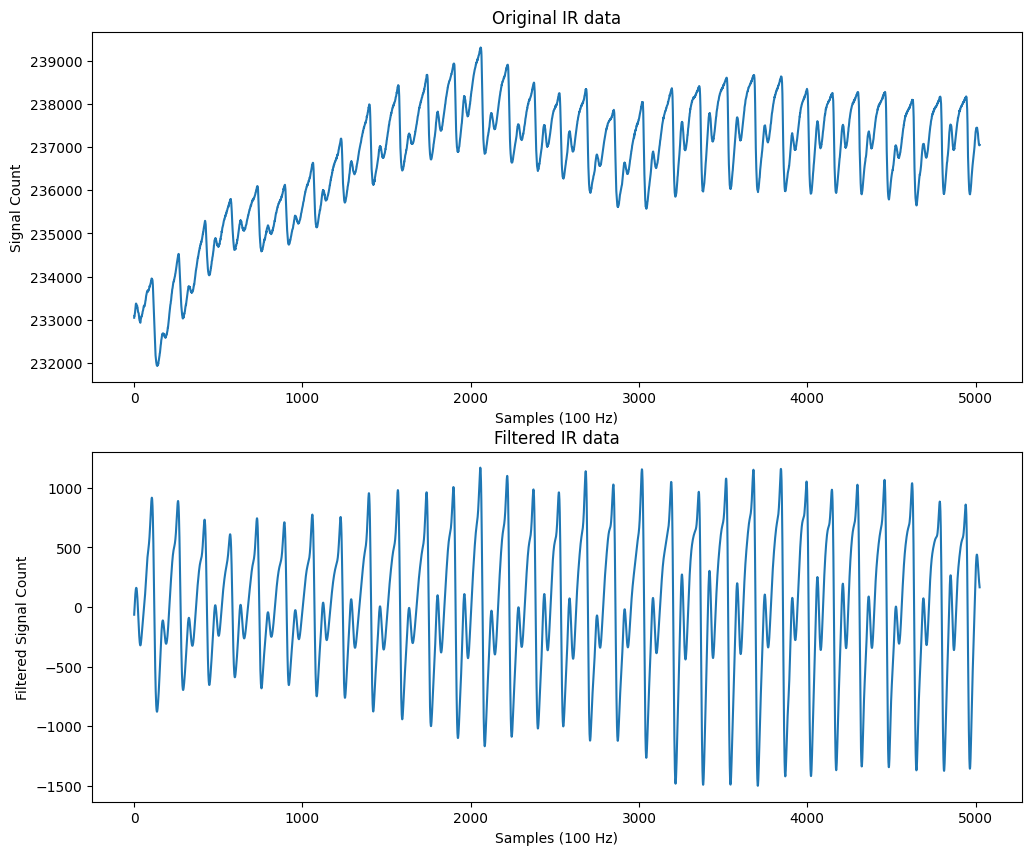

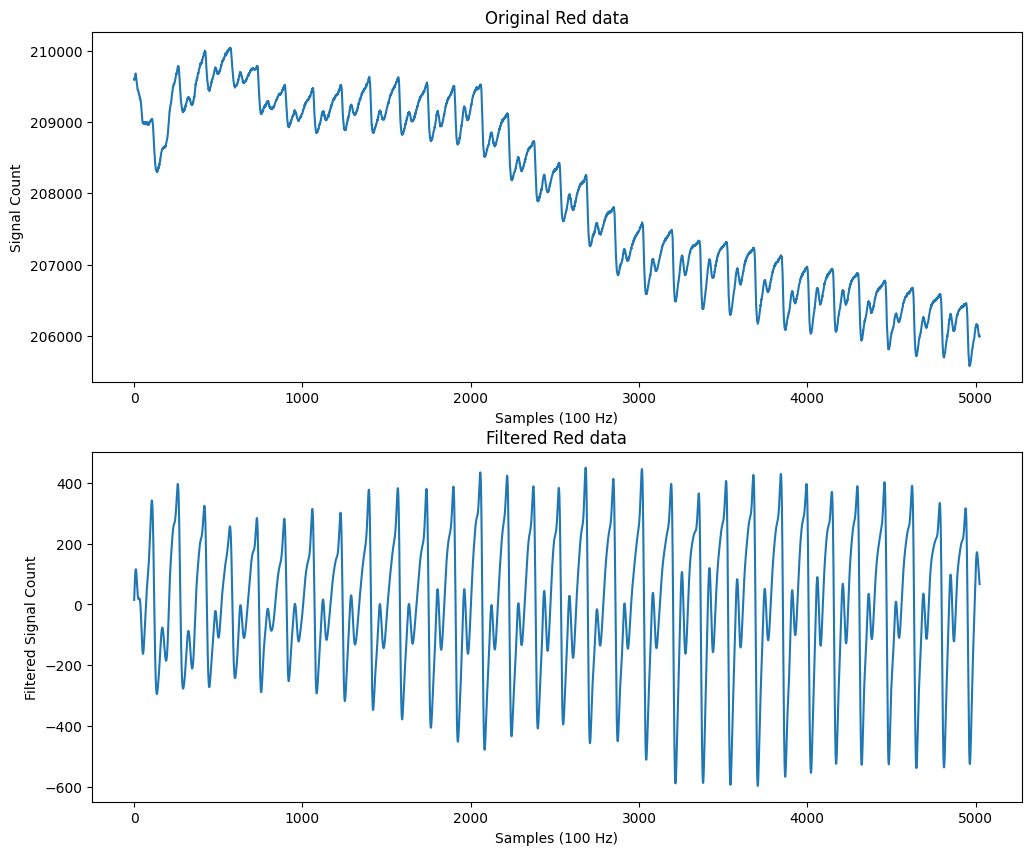

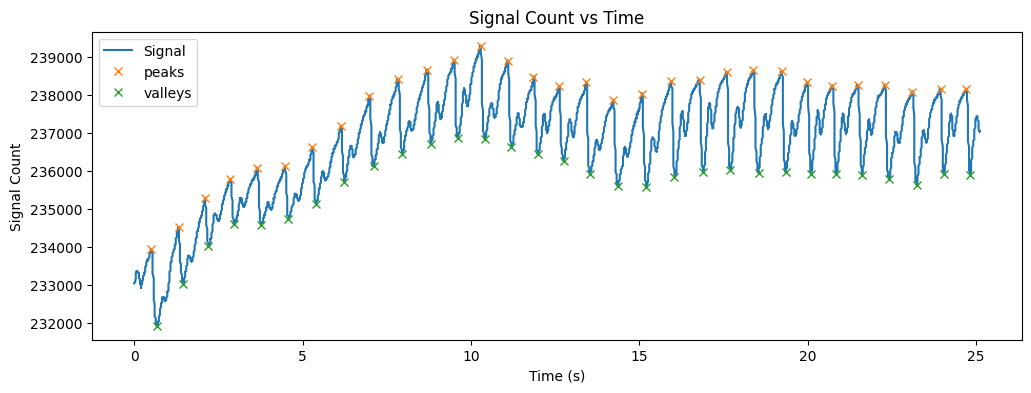

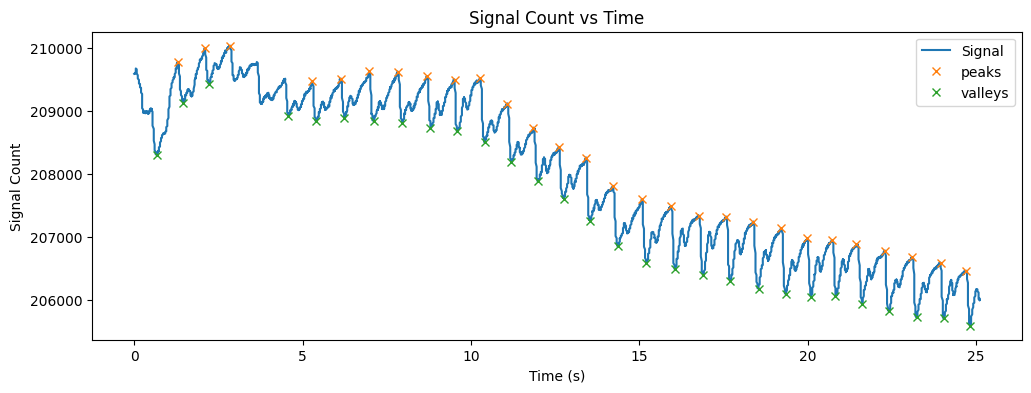

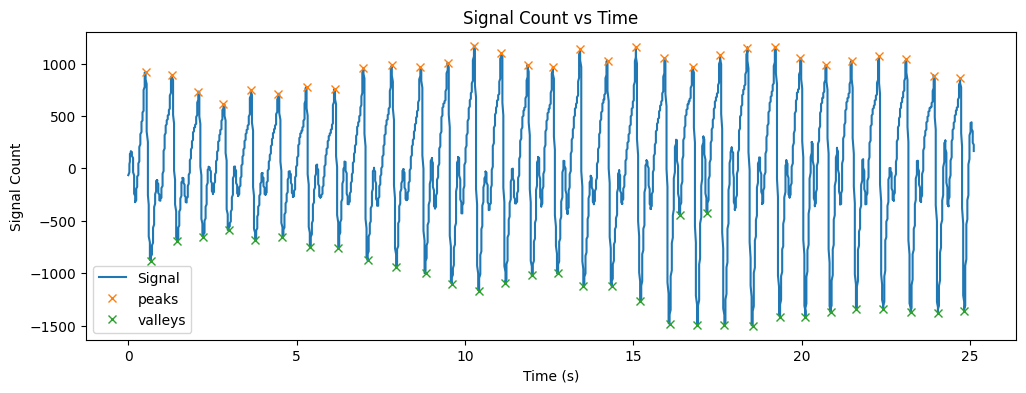

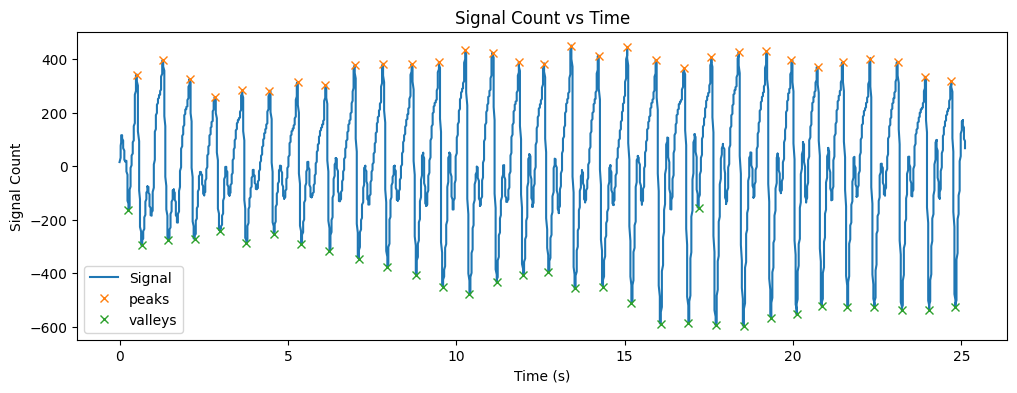

In [53]:
time = convert_to_sec(np.array(df['Time'], dtype='datetime64'))[1]
IR_Count = df[" IR Count"]
Red_Count = df[" Red Count"]
smoothed_IR = smooth_data(df, 'IR')
smoothed_Red = smooth_data(df, 'Red')


peaks_ir, valleys_ir = peak_valley_finder_and_plot(IR_Count.to_numpy(), time, prominence=PROMINENCE_IR)
peaks_red, valleys_red = peak_valley_finder_and_plot(Red_Count.to_numpy(), time, prominence=PROMINENCE_RED)

peaks_ir_smoothed, valleys_ir_smoothed = peak_valley_finder_and_plot(smoothed_IR, time, prominence=500)
peaks_red_smoothed, valleys_red_smoothed = peak_valley_finder_and_plot(smoothed_Red, time, prominence=200)

In [54]:
### USING THE IR COUNT ###
BPM1_vals_ir = BPM1(time, peaks_ir, valleys_ir, compute_moving_average)
BPM2_vals_ir = BPM2(time, peaks_ir, valleys_ir, compute_moving_average)
    
print("-------Based on IR Count-------")
print(f'Average BPM over time interval using peaks: {BPM1_vals_ir[0]:.2f}')
print(f'Average BPM over time interval using valleys: {BPM1_vals_ir[1]:.2f}')
if compute_moving_average:
    print("BPM Moving Average with window length of 5 Heartbeats:")
    print("Based on peaks: ",np.round(BPM1_vals_ir[2], 2))
    print("Based on valleys: ", np.round(BPM1_vals_ir[4], 2))

print()
print("-------Based on IR Count-------")
print(f'Average BPM2 over time interval using peaks: {BPM2_vals_ir[0]:.2f}')
print(f'Average BPM2 over time interval using valleys: {BPM2_vals_ir[1]:.2f}')
if compute_moving_average:
    print("BPM2 Moving Average with window length of 5 Heartbeats:")
    print("Based on peaks: ",np.round(BPM2_vals_ir[2], 2))
    print("Based on valleys: ", np.round(BPM2_vals_ir[3], 2))

### USING THE SMOOTHED IR COUNT ###
BPM1_vals_smoothed_ir = BPM1(time, peaks_ir_smoothed, valleys_ir_smoothed, compute_moving_average)
BPM2_vals_smoothed_ir = BPM2(time, peaks_ir_smoothed, valleys_ir_smoothed, compute_moving_average)

print()
print("-------Based on Smoothed IR Count-------")
print(f'Average BPM over time interval using peaks: {BPM1_vals_smoothed_ir[0]:.2f}')
print(f'Average BPM over time interval using valleys: {BPM1_vals_smoothed_ir[1]:.2f}')
if compute_moving_average:
    print("BPM Moving Average with window length of 5 Heartbeats:")
    print("Based on peaks: ",np.round(BPM1_vals_smoothed_ir[2], 2))
    print("Based on valleys: ", np.round(BPM1_vals_smoothed_ir[3], 2))

print()
print("-------Based on Smoothed IR Count-------")
print(f'Average BPM2 over time interval using peaks: {BPM2_vals_smoothed_ir[0]:.2f}')
print(f'Average BPM2 over time interval using valleys: {BPM2_vals_smoothed_ir[1]:.2f}')
if compute_moving_average:
    print("BPM2 Moving Average with window length of 5 Heartbeats:")
    print("Based on peaks: ",np.round(BPM2_vals_smoothed_ir[2], 2))
    print("Based on valleys: ", np.round(BPM2_vals_smoothed_ir[3], 2))

-------Based on IR Count-------
Average BPM over time interval using peaks: 74.33
Average BPM over time interval using valleys: 74.53

-------Based on IR Count-------
Average BPM2 over time interval using peaks: 74.44
Average BPM2 over time interval using valleys: 74.53

-------Based on Smoothed IR Count-------
Average BPM over time interval using peaks: 74.41
Average BPM over time interval using valleys: 79.50

-------Based on Smoothed IR Count-------
Average BPM2 over time interval using peaks: 74.33
Average BPM2 over time interval using valleys: 79.50


In [55]:
### USING THE RED COUNT ###
BPM1_vals_red = BPM1(time, peaks_red, valleys_red, compute_moving_average)
BPM2_vals_red = BPM2(time, peaks_red, valleys_red, compute_moving_average)

print("-------Based on Red Count-------")
print(f'Average BPM over time interval using peaks: {BPM1_vals_red[0]:.2f}')
print(f'Average BPM over time interval using valleys: {BPM1_vals_red[1]:.2f}')
if compute_moving_average:
    print("BPM Moving Average with window length of 5 Heartbeats:")
    print("Based on peaks: ",np.round(BPM1_vals_red[2], 2))
    print("Based on valleys: ", np.round(BPM1_vals_red[4], 2))

print()
print("-------Based on Red Count-------")
print(f'Average BPM2 over time interval using peaks: {BPM2_vals_red[0]:.2f}')
print(f'Average BPM2 over time interval using valleys: {BPM2_vals_red[1]:.2f}')
if compute_moving_average:
    print("BPM2 Moving Average with window length of 5 Heartbeats:")
    print("Based on peaks: ",np.round(BPM2_vals_red[2], 2))
    print("Based on valleys: ", np.round(BPM2_vals_red[3], 2))

### USING THE SMOOTHED RED COUNT ###
BPM1_vals_smoothed_red = BPM1(time, peaks_red_smoothed, valleys_red_smoothed, compute_moving_average)
BPM2_vals_smoothed_red = BPM2(time, peaks_red_smoothed, valleys_red_smoothed, compute_moving_average)

print()
print("-------Based on Smoothed Red Count-------")
print(f'Average BPM over time interval using peaks: {BPM1_vals_smoothed_red[0]:.2f}')
print(f'Average BPM over time interval using valleys: {BPM1_vals_smoothed_red[1]:.2f}')
if compute_moving_average:
    print("BPM Moving Average with window length of 5 Heartbeats:")
    print("Based on peaks: ",np.round(BPM1_vals_smoothed_red[2], 2))
    print("Based on valleys: ", np.round(BPM1_vals_smoothed_red[3], 2))

print()
print("-------Based on Smoothed Red Count-------")
print(f'Average BPM2 over time interval using peaks: {BPM2_vals_smoothed_red[0]:.2f}')
print(f'Average BPM2 over time interval using valleys: {BPM2_vals_smoothed_red[1]:.2f}')
if compute_moving_average:
    print("BPM2 Moving Average with window length of 5 Heartbeats:")
    print("Based on peaks: ",np.round(BPM2_vals_smoothed_red[2], 2))
    print("Based on valleys: ", np.round(BPM2_vals_smoothed_red[3], 2))

-------Based on Red Count-------
Average BPM over time interval using peaks: 69.21
Average BPM over time interval using valleys: 69.56

-------Based on Red Count-------
Average BPM2 over time interval using peaks: 69.21
Average BPM2 over time interval using valleys: 69.56

-------Based on Smoothed Red Count-------
Average BPM over time interval using peaks: 74.41
Average BPM over time interval using valleys: 78.17

-------Based on Smoothed Red Count-------
Average BPM2 over time interval using peaks: 74.41
Average BPM2 over time interval using valleys: 78.17


In [56]:
avg_red_peak, avg_red_val, avg_ir_peak, avg_ir_val, avg_R, avg_SpO2 = SpO2(Red_Count, IR_Count, peaks_red, valleys_red, peaks_ir, valleys_ir)
print(f"Average Peak Value for Red Channel: {avg_red_peak:.2f} [counts]")
print(f"Average Peak Value for IR Channel: {avg_ir_peak:.2f} [counts]")
print(f"Average Trough Value for Red Channel: {avg_red_val:.2f} [counts]")
print(f"Average Trough Value for IR Channel: {avg_ir_val:.2f} [counts]")
print(f"Average Ratio of Ratios: {avg_R:.2f}")
print(f"Average SpO2: {avg_SpO2:.2f}%")

Average Peak Value for Red Channel: 208229.86 [counts]
Average Peak Value for IR Channel: 237712.65 [counts]
Average Trough Value for Red Channel: 207372.21 [counts]
Average Trough Value for IR Channel: 235616.26 [counts]
Average Ratio of Ratios: 0.46
Average SpO2: 100.27%
